In [1]:
import duckdb
import pickle
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [2]:
# Utilidades
def plot_heatmap(loadings, index):
    df = (
        pl.DataFrame(
            data=loadings,
            schema=[f"fator_{i}" for i in list(range(1, loadings.shape[1] + 1))],
        )
        .with_columns(pl.Series(index).alias("questao"))
        .to_pandas()
        .set_index("questao")
    )

    heat_plot = sns.heatmap(data=df, annot=True, fmt=".1f", cmap="crest")
    return heat_plot

## Carregando os Dados

In [3]:
conn = duckdb.connect("./data/db/enem.duckdb", read_only=True)

query = """
select
    nu_inscricao,
    educacao_pai,
    educacao_mae,
    ocupacao_pai,
    ocupacao_mae,
    num_pessoas_residencia,
    renda_familia,
    empregado_domestico,
    residencia_banheiros,
    residencia_quartos,
    residencia_carros,
    residencia_motocicleta,
    residencia_geladeira,
    residencia_freezer,
    residencia_maquina_lava_roupa,
    residencia_maquina_seca_roupa,
    residencia_microondas,
    residencia_lava_louca,
    residencia_aspirador_po,
    residencia_tv_cores,
    residencia_dvd,
    residencia_tv_assinatura,
    residencia_tel_celular,
    residencia_tel_fixo,
    residencia_computador,
    residencia_internet
from
    enem_intermediate.int_enem_questionario
"""


enem_df = conn.sql(query=query).pl()

conn.close()

In [4]:
enem_df.head()

NU_INSCRICAO,educacao_pai,educacao_mae,ocupacao_pai,ocupacao_mae,num_pessoas_residencia,renda_familia,empregado_domestico,residencia_banheiros,residencia_quartos,residencia_carros,residencia_motocicleta,residencia_geladeira,residencia_freezer,residencia_maquina_lava_roupa,residencia_maquina_seca_roupa,residencia_microondas,residencia_lava_louca,residencia_aspirador_po,residencia_tv_cores,residencia_dvd,residencia_tv_assinatura,residencia_tel_celular,residencia_tel_fixo,residencia_computador,residencia_internet
i64,i32,i32,i32,i32,i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
210059085136,1,6,5,4,5,6,3,3,4,3,4,3,2,2,4,3,3,2,2,1,2,2,1,1,2
210059527735,6,5,5,2,3,8,1,2,3,3,1,2,2,2,1,2,1,2,2,1,1,3,1,4,2
210061103945,0,5,3,0,5,3,1,2,4,2,1,2,1,2,1,2,1,1,2,1,1,1,1,1,2
210060214087,4,4,2,2,5,3,1,2,2,1,1,2,1,1,1,1,1,1,2,1,1,4,1,1,2
210059980948,2,2,1,1,4,2,1,2,1,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1,1


In [5]:
nome_questoes = enem_df.drop("NU_INSCRICAO").head().columns

### Teste de Barlett

In [6]:
chi_square_value, p_value = calculate_bartlett_sphericity(
    enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas()
)

In [7]:
chi_square_value, p_value

(np.float64(31805057.097406894), np.float64(0.0))

### Teste de Kaiser-Meyer-Olkin

In [8]:
kmo_all, kmo_model = calculate_kmo(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

c:\Users\slopes\Projetos\analytics-enem\.venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [9]:
kmo_model

np.float64(0.941896613224189)

### Escolhendo o número de fatores

In [10]:
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

ev, v = fa.get_eigenvalues()

ev

array([7.75734001, 1.58637073, 1.35698723, 1.19535439, 1.00113838,
       0.9186578 , 0.90351623, 0.83516138, 0.80990309, 0.79879066,
       0.74569984, 0.69319603, 0.66279216, 0.63697967, 0.61073147,
       0.58425107, 0.5578113 , 0.52239802, 0.50055284, 0.46969511,
       0.45530458, 0.43972115, 0.34178925, 0.33282969, 0.28302793])

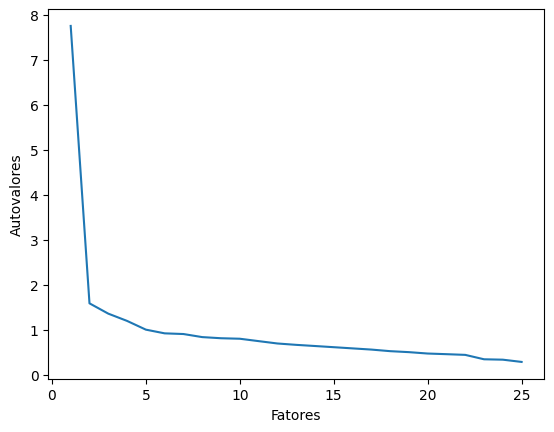

In [11]:
plt.plot(range(1, len(ev) + 1), ev)
plt.xlabel("Fatores")
plt.ylabel("Autovalores")
plt.show()

Como critério, vamos escolher os números de fatores com autovalores maior do que 1, que são os que explicam mais variância do conjunto de dados do que uma única variável.

Nesse caso, são 5 fatores. Vamos começar a análise com 5 fatores e ir diminuindo, até entender o que explica melhor a correlação do conjunto de dados.

### 5 Fatores

<Axes: ylabel='questao'>

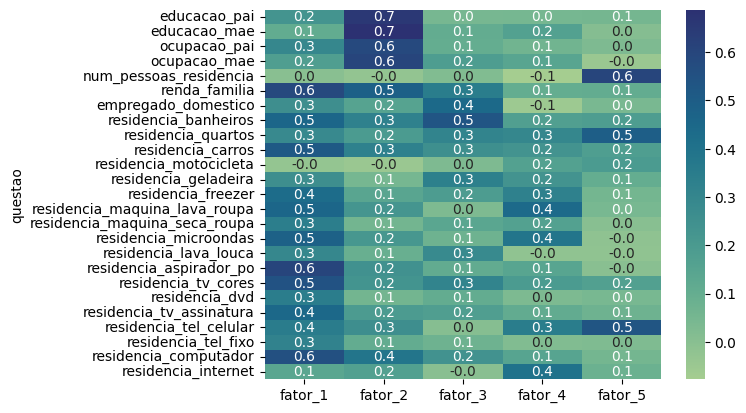

In [12]:
fa5f = FactorAnalyzer(n_factors=5, rotation="varimax", impute="median")
fa5f.fit(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

plot_heatmap(fa5f.loadings_, nome_questoes)

fator_1 muito correlacionado com questões sobre *ter* coisas na residencia. Ou seja, indica ser uma medida de renda familiar.

fator_2 mais correlacionado com fatores familiares, como educação e ocupação dos pais. Também é correlacionado com renda, mas não tanto quanto sobre posses.

fator_3 e fator_4 não mostram padrões interessantes de se observar.

fator_5 parece ser correlacionado com questões que indicam a quantidade de pessoas na familia. Como nº de pessoas, nº de quartos e nº de celulares.

### 4 fatores

<Axes: ylabel='questao'>

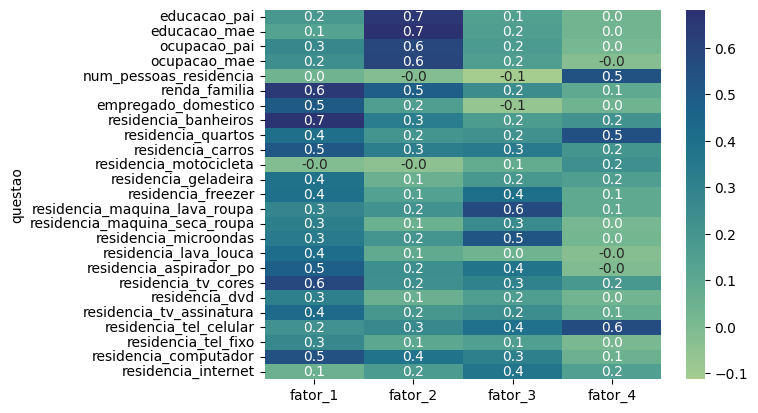

In [13]:
fa4f = FactorAnalyzer(n_factors=4, rotation="varimax")
fa4f.fit(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

plot_heatmap(fa4f.loadings_, nome_questoes)

Comentários são os mesmos no caso de 5 fatores. Dessa vez, fator_3 parece o fator não tão importante, e o fator_5 virou o fator_4. Tudo indica três fatores com padrões de correlações com questionários do enem.

### 3 Fatores

<Axes: ylabel='questao'>

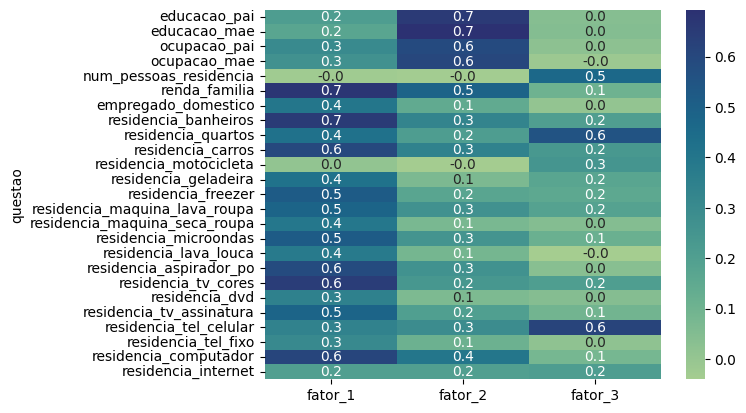

In [14]:
fa3f = FactorAnalyzer(n_factors=3, rotation="varimax")
fa3f.fit(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

plot_heatmap(fa3f.loadings_, nome_questoes)

Os três fatores se correlacionam, cada um, com três características no estudante:
- fator_1: correlação com posses, de eletrônicos, eletrodomésticos, carros e etc.
- fator_2: correlação com histórico familiar, como educação e ocupação dos pais.
- fator_3: com tamanho da família, pelo número de pessoas na residência, número de quartos e celulares.

O fator_3, apesar do padrão observado, talvez seja melhor só manter a variável "num_pessoas_residencia" separada.

### 2 Fatores

<Axes: ylabel='questao'>

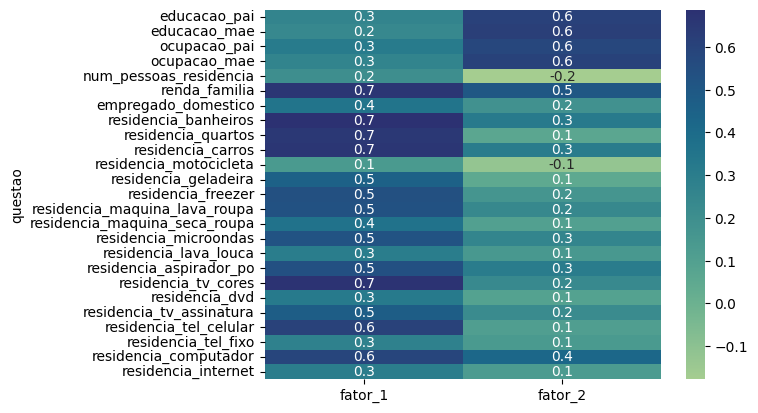

In [17]:
fa2f = FactorAnalyzer(n_factors=2, rotation="varimax")
fa2f.fit(enem_df.drop(pl.col("NU_INSCRICAO")).to_pandas())

plot_heatmap(fa2f.loadings_, nome_questoes)

Com dois fatores chegamos a dois padrões bem claros e separados.
- fator_1: correlações com posse. Vamos chamar de *Índice Patrimonial*
- fator_2: correlação com o status da família. Vamos chamar de *Índice de Herança*

Vamos finalizar com dois fatores e vamos carregar os dois índices na base.